<a href="https://colab.research.google.com/github/DanieleCecca/PROSAIL-Retrieval-of-biophysical-variables-Cab-with-ML-DL-approaches/blob/main/Prosail_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROSAIL-Retrieval of biophysical variables (Cab) with ML/DL approaches


*Daniele Cecca*

*Matr. 914358*

*MSc Artificial Intelligence for Science and Technology*

*Email: d.cecca@campus.unimib.it*

This work builds an end-to-end pipeline that connects the PROSAIL radiative transfer simulation to the mapping of biophysical parameters (with a focus on Cab, chlorophyll content) from Sentinel-2 images.

In summary:
1. Synthetic spectral signatures are generated with PROSAIL and mapped to Sentinel-2 bands;
2. Regressor (Random Forest) is trained on these data to predict Cab;
3. Sentinel-2 images over an area of interest are downloaded (via Google Earth Engine)and locally processed to produce Cab maps and a time series (2019–2024) displayed interactively.

## Imports and environment setup

In [ ]:
!pip install prosail -q
!pip install rasterio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 44.9 MB/s eta 0:00:00


In [ ]:
import prosail
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import ee
import geemap

import rasterio

import glob
import rasterio
from datetime import datetime
import re
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
ee.Authenticate()

In [ ]:
ee.Initialize(project='versatile-lotus-462612-h1')

## Constants

In [ ]:
DATA_PATH='/content/drive/MyDrive/Prosail_project'

In [ ]:
# Sentinel-2 spectral ranges in nanometers i use the ones  20- 10 resolution
SENTINEL2_BANDS = {
    'B2':  (463, 523),
    'B3':  (543, 577),
    'B4':  (650, 680),
    'B5':  (695, 715),
    'B6':  (731, 749),
    'B7':  (770, 792),
    'B8':  (833, 865),
    'B8A': (855, 875),
    'B11': (1565, 1655),
    'B12': (2100, 2280),
}

In [ ]:
BANDS=[k for k in SENTINEL2_BANDS.keys()]

In [ ]:
geoJSON={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              16.72061333756332,
              40.80420481407401
            ],
            [
              16.72061333756332,
              40.79936332501018
            ],
            [
              16.72844673025719,
              40.79936332501018
            ],
            [
              16.72844673025719,
              40.80420481407401
            ],
            [
              16.72061333756332,
              40.80420481407401
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

## Functions

###  PROSAIL synthetic data functions


In [ ]:
def generate_prosail_parameters():
  lidf_types = {
      0: (-0.35, -0.15),  # Spherical
      1: (0.0, 0.0),      # Uniform
      2: (-1.0, 0.0),     # Erectophile
      3: (0.0, -1.0),     # Plagiophile
      4: (1.0, 0.0),      # Planophile
      5: (0.0, 1.0),      # Extremophile
  }

  typelidf = np.random.choice(list(lidf_types.keys()))
  lidfa, lidfb = lidf_types[typelidf]

  params = {
      'N': np.random.uniform(0.8, 2.5),
      'Cab': np.random.uniform(0, 80),       # µg/cm²
      'Car': np.random.uniform(0, 20),       # µg/cm²
      'Cbrown': np.random.uniform(0, 1),     # arbitrary units
      'Cw': np.random.uniform(0, 0.2),        # cm (200 mm = 0.2 cm)
      'Cm': np.random.uniform(0, 0.02),      # g/cm² (200 g/m² = 0.02 g/cm²)
      'LAI': np.random.uniform(0, 10),
      'psoil': np.random.uniform(0, 1),      # wet = 0, dry = 1
      'rsoil': 1.0,                          # default or fixed
      'hspot': np.random.uniform(0, 1),
      'tts': np.random.uniform(0, 90),       # solar zenith angle
      'tto': np.random.uniform(0, 90),       # observer zenith angle
      'psi': np.random.uniform(0, 360),      # relative azimuth angle
      'typelidf': typelidf,
      'lidfa': lidfa,
      'lidfb': lidfb,
  }

  return params


In [ ]:
def add_gaussian_noise(reflectance, std_dev=0.01):
    noise = np.random.normal(0, std_dev, size=reflectance.shape)
    noisy_reflectance = reflectance + noise
    return noisy_reflectance

In [ ]:
def generate_prosail_data(n_samples,noise_ratio=0.3):
    spectral_signatures = []
    parameters = []

    for _ in range(n_samples):
        params = generate_prosail_parameters()
        refl = prosail.run_prosail(
            n=params['N'],
            cab=params['Cab'],
            car=params['Car'],
            cbrown=params['Cbrown'],
            cw=params['Cw'],
            cm=params['Cm'],
            lai=params['LAI'],
            lidfa=params['lidfa'],
            lidfb=params['lidfb'],
            psoil=params['psoil'],
            rsoil=params['rsoil'],
            hspot=params['hspot'],
            tts=params['tts'],
            tto=params['tto'],
            psi=params['psi']
        )

        if np.random.rand() < noise_ratio:
            refl = add_gaussian_noise(refl)
        refl = np.clip(refl, 0, 1)  # mantiene valori validi

        spectral_signatures.append(refl)
        parameters.append(params)

    return np.array(spectral_signatures), parameters

In [ ]:
def show_spectral_signature(spectral_signature):
  wavelengths = np.arange(400, 2501)
  reflectance = spectral_signature

  plt.plot(wavelengths, reflectance, label='Simulated spectrum', color='green')
  plt.xlabel('Wavelength (nm)')
  plt.ylabel('Reflectance')
  plt.title('PROSAIL Simulated Reflectance Spectrum')
  plt.grid(True)
  plt.legend()
  plt.show()


In [ ]:
def show_multiple_spectra(spectral_signatures, params_list=None):
    wavelengths = np.arange(400, 2501)

    plt.figure(figsize=(10, 6))
    for i, refl in enumerate(spectral_signatures):
        label = f"Sample {i+1}"
        if params_list:
            label += f" | CAB={params_list[i]['Cab']:.2f}"
        plt.plot(wavelengths, refl, label=label)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('PROSAIL Simulated Reflectance Spectra')
    plt.grid(True)
    plt.legend(loc='upper right', fontsize='small')
    plt.tight_layout()
    plt.show()


###  Sentinel-2 functions

In [ ]:
def map_to_sentinel2_bands(spectral_signature):
  wavelengths = np.arange(400, 2501)
  band_values = {}

  for band, (low, high) in SENTINEL2_BANDS.items():
      mask = (wavelengths >= low) & (wavelengths <= high)
      if np.any(mask):
          band_values[band] = np.mean(spectral_signature[mask])
      else:
          band_values[band] = np.nan

  return band_values

In [ ]:
def generate_sentinel2_data(spectral_signatures):
  bands=[]
  for spectral_signature in spectral_signatures:
      band_values = map_to_sentinel2_bands(spectral_signature)
      bands.append(band_values)
  return bands

In [ ]:
def show_sentinel2_signature(band_values, connect=True):

    band_names = list(band_values.keys())
    reflectances = list(band_values.values())

    # Approximate center wavelengths for plotting (in nm)
    band_centers = {
        'B2': 490, 'B3': 560, 'B4': 665,
        'B5': 705, 'B6': 740, 'B7': 783, 'B8': 842,
        'B8A': 865, 'B11': 1610, 'B12': 2190
    }

    centers = [band_centers[b] for b in band_names]

    plt.figure(figsize=(10, 5))
    if connect:
        plt.plot(centers, reflectances, marker='o', linestyle='-', color='blue')
    else:
        plt.scatter(centers, reflectances, color='blue')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Sentinel-2 Simulated Spectral Signature')
    plt.grid(True)
    plt.xticks(centers, band_names, rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_multiple_sentinel2_signatures(band_values_list, labels=None, connect=True):
    # Approximate center wavelengths for plotting (in nm)
    band_centers = {
        'B2': 490, 'B3': 560, 'B4': 665,
        'B5': 705, 'B6': 740, 'B7': 783, 'B8': 842,
        'B8A': 865, 'B11': 1610, 'B12': 2190
    }

    band_order = list(band_centers.keys())
    centers = [band_centers[b] for b in band_order]

    plt.figure(figsize=(10, 6))

    for i, band_values in enumerate(band_values_list):
        reflectances = [band_values.get(b, np.nan) for b in band_order]
        label = labels[i] if labels and i < len(labels) else f"Sample {i+1}"

        if connect:
            plt.plot(centers, reflectances, marker='o', linestyle='-', label=label)
        else:
            plt.scatter(centers, reflectances, label=label)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Sentinel-2 Simulated Spectral Signatures')
    plt.grid(True)
    plt.xticks(centers, band_order, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Dataset creation functions

In [ ]:
def create_dataset(sentinel2_signatures,parameters):
  param_df = pd.DataFrame(parameters)
  spectral_df = pd.DataFrame(sentinel2_signatures)
  dataset = pd.concat([spectral_df, param_df], axis=1)
  path=os.path.join(DATA_PATH,'prosail_full_dataset.csv')
  dataset.to_csv(path, index=False)

In [ ]:
def load_dataset(y_param='Cab'):
  path=os.path.join(DATA_PATH,'prosail_full_dataset.csv')
  dataset = pd.read_csv(path)
  dataset=dataset[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A','B11', 'B12',y_param]]
  return dataset


### Validation on Sentinel-2 functions

In [ ]:
def create_monthly_image(year_filtered , year, month):
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        # Filter images for the specific month
        month_filtered = year_filtered.filter(ee.Filter.date(start_date, end_date))

        # Sort the filtered collection by cloud cover
        month_filtered = month_filtered.sort('CLOUDY_PIXEL_PERCENTAGE')

        # Take the irst images(TO DO i should take the mean?)
        first = month_filtered.first()

        return first

In [ ]:
def create_monthly_images_for_year(year, collection):
    # Filter the collection to get images for the specified year
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    year_filtered = collection.filter(ee.Filter.date(start_date, end_date))

    # Create a list of months (1 to 12)
    months = list(range(1, 13))

    # Map the function over the list of months to create monthly images
    monthly_images = [create_monthly_image(year_filtered,year,month) for month in months]

    return monthly_images

In [ ]:
def clip_and_resample(image):
    return image.clip(roi).resample('bilinear').reproject(crs='EPSG:32632', scale=20)

In [ ]:
# Normalizza una singola immagine rispetto ai min/max della collezione
def normalize_image(img, collection, bands):
    norm_bands = []
    for band in bands:
        band_img = img.select(band)
        min_val = collection.select(band).reduce(ee.Reducer.min()).rename('min')
        max_val = collection.select(band).reduce(ee.Reducer.max()).rename('max')

        # normalizzazione (minmax)
        norm_band = band_img.subtract(min_val).divide(max_val.subtract(min_val))
        norm_band = norm_band.rename(band)
        norm_bands.append(norm_band)

    return ee.Image(norm_bands).copyProperties(img, img.propertyNames())

In [ ]:
def minmax_normalize_collection(collection, bands):
    return collection.map(lambda img: normalize_image(img, collection, bands))

In [ ]:
def export_collection_to_drive(collection, folder='GEE_Export', scale=10, crs=None):
    # Numero di immagini
    n = collection.size().getInfo()
    img_list = collection.toList(n)

    for i in range(n):
        img = ee.Image(img_list.get(i))

        # Nome file: prima system:index, altrimenti data
        name = img.get('system:index').getInfo()
        if not name:
            name = ee.Date(img.get('system:time_start')).format('YYYYMMdd_HHmmss').getInfo()

        params = {
            'image': img,
            'description': f'export_{name}',
            'folder': folder,
            'fileNamePrefix': name,
            'scale': scale,
            'region': img.geometry(),
            'maxPixels': 1e13
        }
        if crs is not None:
            params['crs'] = crs

        task = ee.batch.Export.image.toDrive(**params)
        task.start()
        print(f'Avviato export: {name}')

In [ ]:
def parse_date_from_name(name: str):
    base = os.path.basename(name)
    date_regexes = [
    re.compile(r"(\d{8})"),                    # YYYYMMDD
    re.compile(r"(\d{4}-\d{2}-\d{2})"),        # YYYY-MM-DD
  ]
    for rx in date_regexes:
        m = rx.search(base)
        if m:
            token = m.group(1)
            try:
                if len(token) == 8:
                    return datetime.strptime(token, "%Y%m%d")
                else:
                    return datetime.strptime(token, "%Y-%m-%d")
            except Exception:
                pass
    return None  # se non trovata, useremo l'ordinamento del nome

In [ ]:
def predict_map_from_tif(path, model, feature_names=None, save_csv_path=None, target_name="Cab"):
    with rasterio.open(path) as src:
        stack = src.read()  # (bands, H, W)
        H, W = stack.shape[1], stack.shape[2]
        profile = src.profile

    # (H, W, C)
    img = np.transpose(stack, (1, 2, 0))
    C = img.shape[2]

    # Flatten
    X = img.reshape(-1, C)
    mask = np.all(~np.isnan(X), axis=1)

    # Costruisci DataFrame con nomi colonne
    if feature_names is None:
        feature_names = [f"B{i+1}" for i in range(C)]
    X_df = pd.DataFrame(X[mask], columns=feature_names)

    # Predizioni
    y = np.full((H * W,), np.nan, dtype=float)
    if np.any(mask):
        y_pred = model.predict(X_df)
        y[mask] = y_pred.astype(float)

    if save_csv_path is not None:
        out_df = pd.concat([X_df, pd.Series(y[mask], name=target_name)], axis=1)
        out_df.to_csv(save_csv_path, index=False)

    cab = y.reshape(H, W)
    return cab, profile

In [ ]:
def build_timeseries(folder, pattern, model):
    files = glob.glob(os.path.join(folder, pattern))
    if not files:
        raise FileNotFoundError(f"Nessun file trovato con pattern {pattern} in {folder}")

    # Ordina per data se possibile, altrimenti per nome
    tagged = []
    for f in files:
        d = parse_date_from_name(f)
        tagged.append((f, d))
    tagged.sort(key=lambda x: (x[1] is None, x[1] or datetime.max, os.path.basename(x[0])))

    maps = []
    dates = []
    prof = None

    for f, d in tagged:
        cab_map, prof = predict_map_from_tif(f, model,BANDS,DATA_PATH+f'/sentinel_csv/{d}.csv')
        maps.append(cab_map)
        dates.append(d or os.path.basename(f))  # se data mancante, usa filename

    # stack -> (T, H, W)
    ts = np.stack(maps, axis=0)
    return ts, dates, prof


In [ ]:
def show_plotly_timeseries(ts, dates=None, title="Cab map (Plotly)"):
    """
    ts: np.ndarray of shape (T, H, W) with floats (NaN allowed)
    dates: list of datetime or str of length T (optional)
    """
    assert ts.ndim == 3, "ts must be (T, H, W)"
    T, H, W = ts.shape
    if dates is None:
        dates = [f"t={i}" for i in range(T)]
    else:
        dates = [d.strftime("%Y-%m-%d") if hasattr(d, "strftime") else str(d) for d in dates]

    # Global color range for consistent scale across frames
    vmin = float(np.nanmin(ts))
    vmax = float(np.nanmax(ts))

    # Initial frame
    fig = go.Figure(
        data=[
            go.Heatmap(
                z=ts[0],
                zmin=vmin, zmax=vmax,
                colorbar=dict(title="Cab (µg/cm²)"),
                hoverinfo="skip"  # turn off noisy hover for dense rasters
            )
        ],
        layout=go.Layout(
            title=f"{title} – {dates[0]}",
            xaxis=dict(showticklabels=False),
            yaxis=dict(showticklabels=False, scaleanchor="x", scaleratio=1),
            margin=dict(l=10, r=10, t=50, b=10),
            updatemenus=[{
                "type": "buttons",
                "x": 1.05, "y": 1.15, "xanchor": "right",
                "buttons": [
                    {"label": "▶ Play", "method": "animate",
                     "args": [None, {"frame": {"duration": 500, "redraw": True},
                                     "fromcurrent": True, "transition": {"duration": 0}}]},
                    {"label": "⏸ Pause", "method": "animate",
                     "args": [[None], {"mode": "immediate",
                                       "frame": {"duration": 0, "redraw": False},
                                       "transition": {"duration": 0}}]}
                ]
            }]
        ),
        frames=[
            go.Frame(
                data=[go.Heatmap(z=ts[i], zmin=vmin, zmax=vmax, hoverinfo="skip")],
                name=str(i),
                layout=go.Layout(title=f"{title} – {dates[i]}")
            )
            for i in range(T)
        ]
    )

    # Slider
    fig.update_layout(
        sliders=[{
            "active": 0,
            "x": 0.05, "y": -0.05, "len": 0.9,
            "pad": {"t": 30},
            "currentvalue": {"prefix": "Time: ", "visible": True},
            "steps": [
                {"label": dates[i], "method": "animate",
                 "args": [[str(i)], {"mode": "immediate",
                                     "frame": {"duration": 0, "redraw": True},
                                     "transition": {"duration": 0}}]}
                for i in range(T)
            ]
        }]
    )

    fig.show()


## Synthetic data generation

### PROSAIL generation

The PROSAIL model combines the PROSPECT model (for leaf reflectance and transmittance) and the SAIL model (for canopy radiative transfer) to simulate the spectral reflectance of vegetation canopies. The model takes several biophysical parameters as inputs.

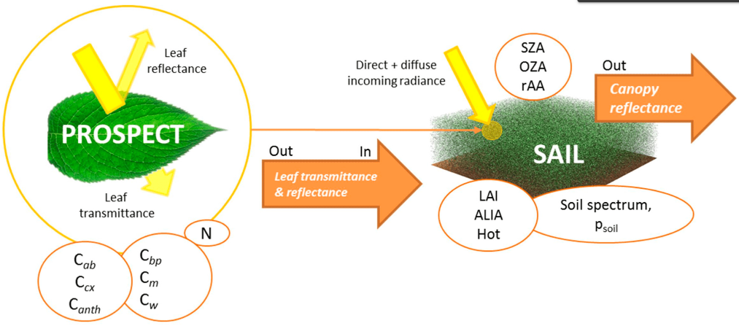

I generate 10,000 synthetic spectral signatures by randomly sampling the PROSAIL model parameters.  
To better approximate real-world conditions, Gaussian noise is added to the reflectance values:  

$$
R'(\lambda) = R(\lambda) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$
  

This process helps the regressor generalize to real Sentinel-2 data by introducing variability.


In [ ]:
spectral_signatures,parameters=generate_prosail_data(10000)

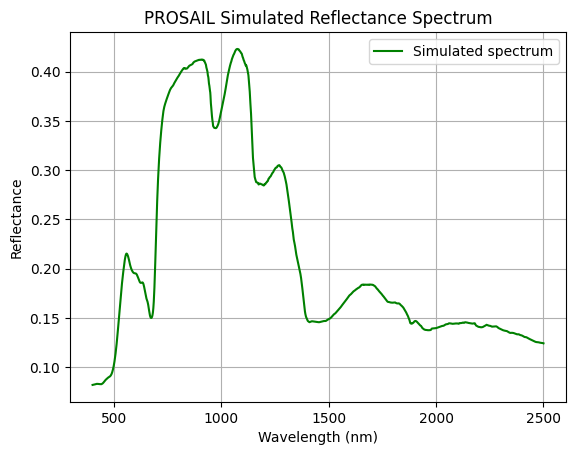

In [ ]:
show_spectral_signature(spectral_signatures[0])

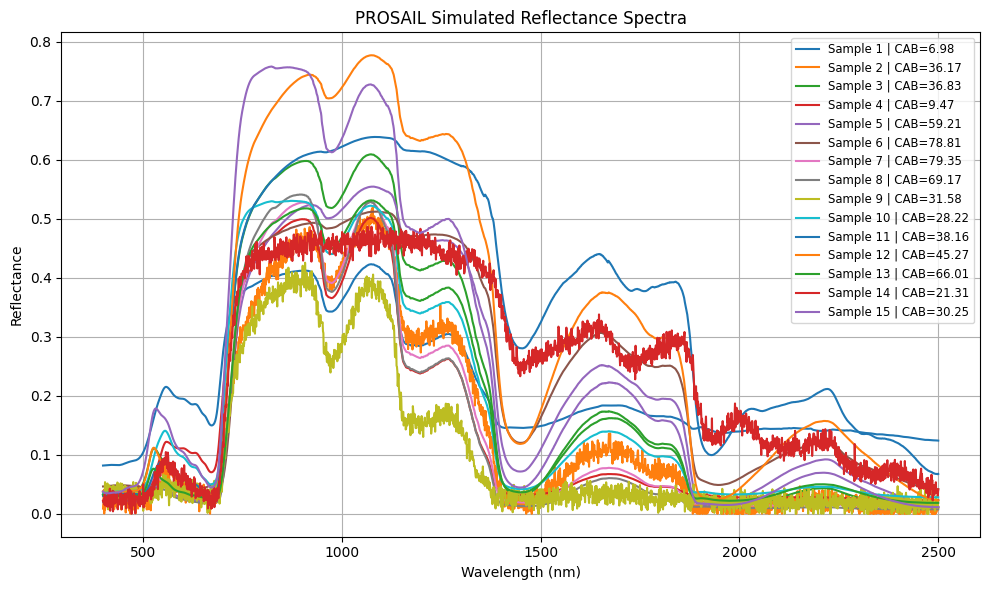

In [ ]:
show_multiple_spectra(spectral_signatures[0:15], parameters)

### Mappig to Sentinel-2 bands

The PROSAIL model produces a continuous spectral signature (reflectance values from 400–2500 nm at 1 nm resolution).  
Sentinel-2, instead, provides reflectance only in a set of discrete spectral bands, each defined by a central wavelength and bandwidth.  

To make the PROSAIL outputs comparable to Sentinel-2 data, for each Sentinel-2 band with wavelength interval $[ \lambda_{\text{low}}, \lambda_{\text{high}} ]$, we compute the mean reflectance of the PROSAIL spectrum within that range.

As a result, each PROSAIL-generated spectral signature (continuous, ~2100 wavelengths) is reduced to a Sentinel-2–like signature with only the most reliable bands.  

In [ ]:
sentinel2_signatures=generate_sentinel2_data(spectral_signatures)

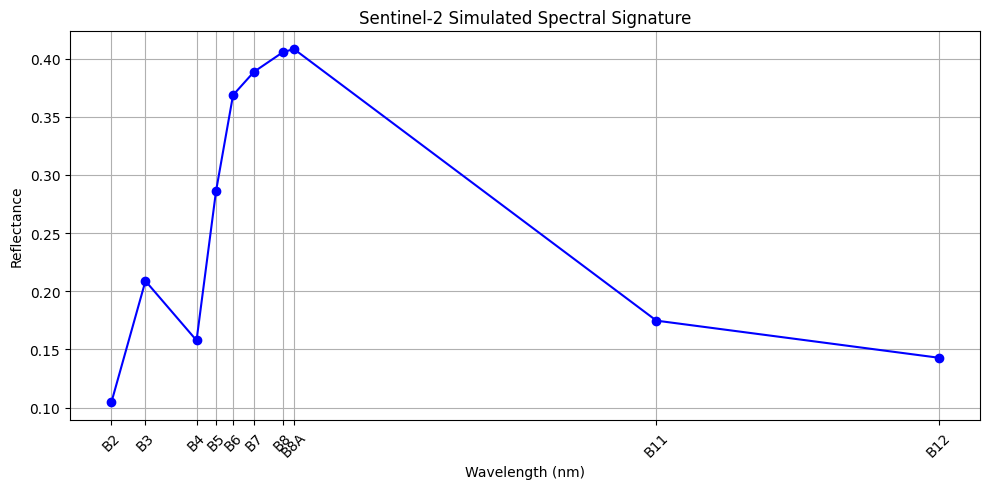

In [ ]:
show_sentinel2_signature(sentinel2_signatures[0])


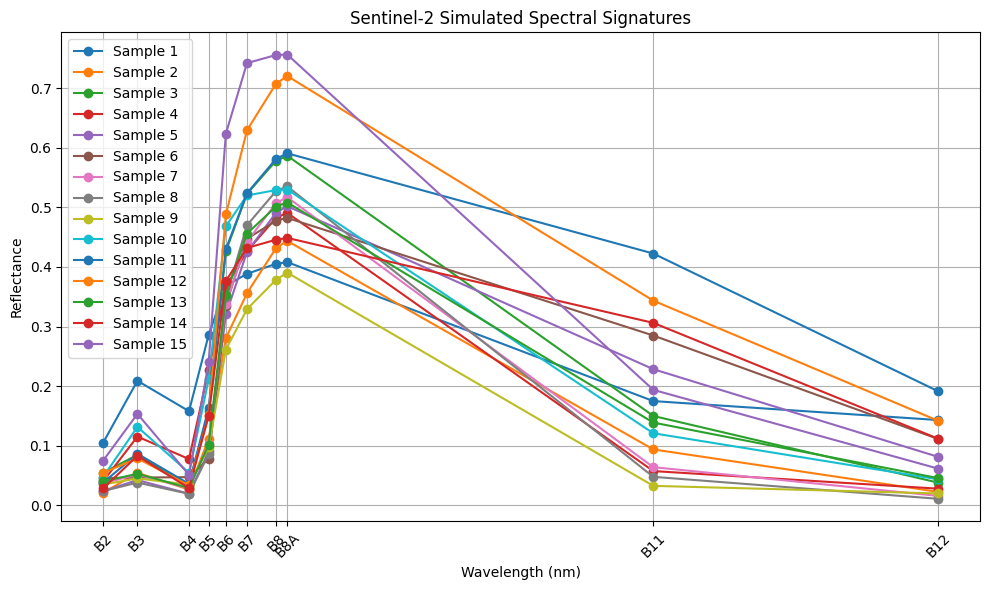

In [ ]:
show_multiple_sentinel2_signatures(sentinel2_signatures[0:15])

### Dataset creation

Now I create a dataset where each sample will be the sintentic mapped signature, and as feature I will have the different band.

In [ ]:
create_dataset(sentinel2_signatures,parameters)

In [ ]:
data=load_dataset()
data.describe()

B2            B3            B4            B5            B6  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.046000      0.094074      0.061936      0.165644      0.382268   
std        0.027000      0.065616      0.062326      0.092153      0.104263   
min        0.014572      0.018064      0.011168      0.032655      0.060690   
25%        0.031281      0.049064      0.028292      0.099975      0.309698   
50%        0.037889      0.074066      0.036577      0.141217      0.373025   
75%        0.049339      0.118661      0.066508      0.208445      0.444917   
max        0.434480      1.000000      0.693149      1.000000      1.000000   

                 B7            B8           B8A           B11           B12  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.468701      0.515870      0.522953      0.124558      0.052393   
std        0.121174      0.123951      0.124705      0.104653      0.068716   
min        0.068911      0.077815      0.081160      0.015856      0.006270   
25%        0.387701      0.435423      0.442004      0.050691      0.015117   
50%        0.462554      0.512511      0.519597      0.086503      0.022443   
75%        0.542988      0.595710      0.603786      0.164027      0.057855   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                Cab  
count  10000.000000  
mean      40.042306  
std       23.171376  
min        0.002755  
25%       19.920023  
50%       40.491276  
75%       60.245098  
max       79.997649

To check the presence of outlier I plot the boxplot of features and thei distribution.

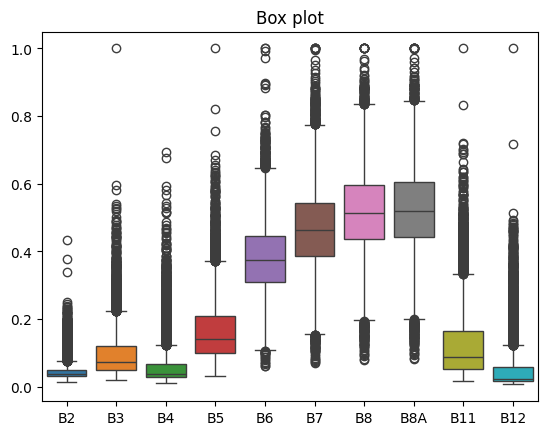

In [ ]:
sns.boxplot(data.drop('Cab',axis=1))
plt.title(f'Box plot')
plt.show()

Check the distribution of the target feauture **Cab** could be also useful to verify if our dataset is balanced.
And in this case,by whatching the picture I can conclude that is balanced.

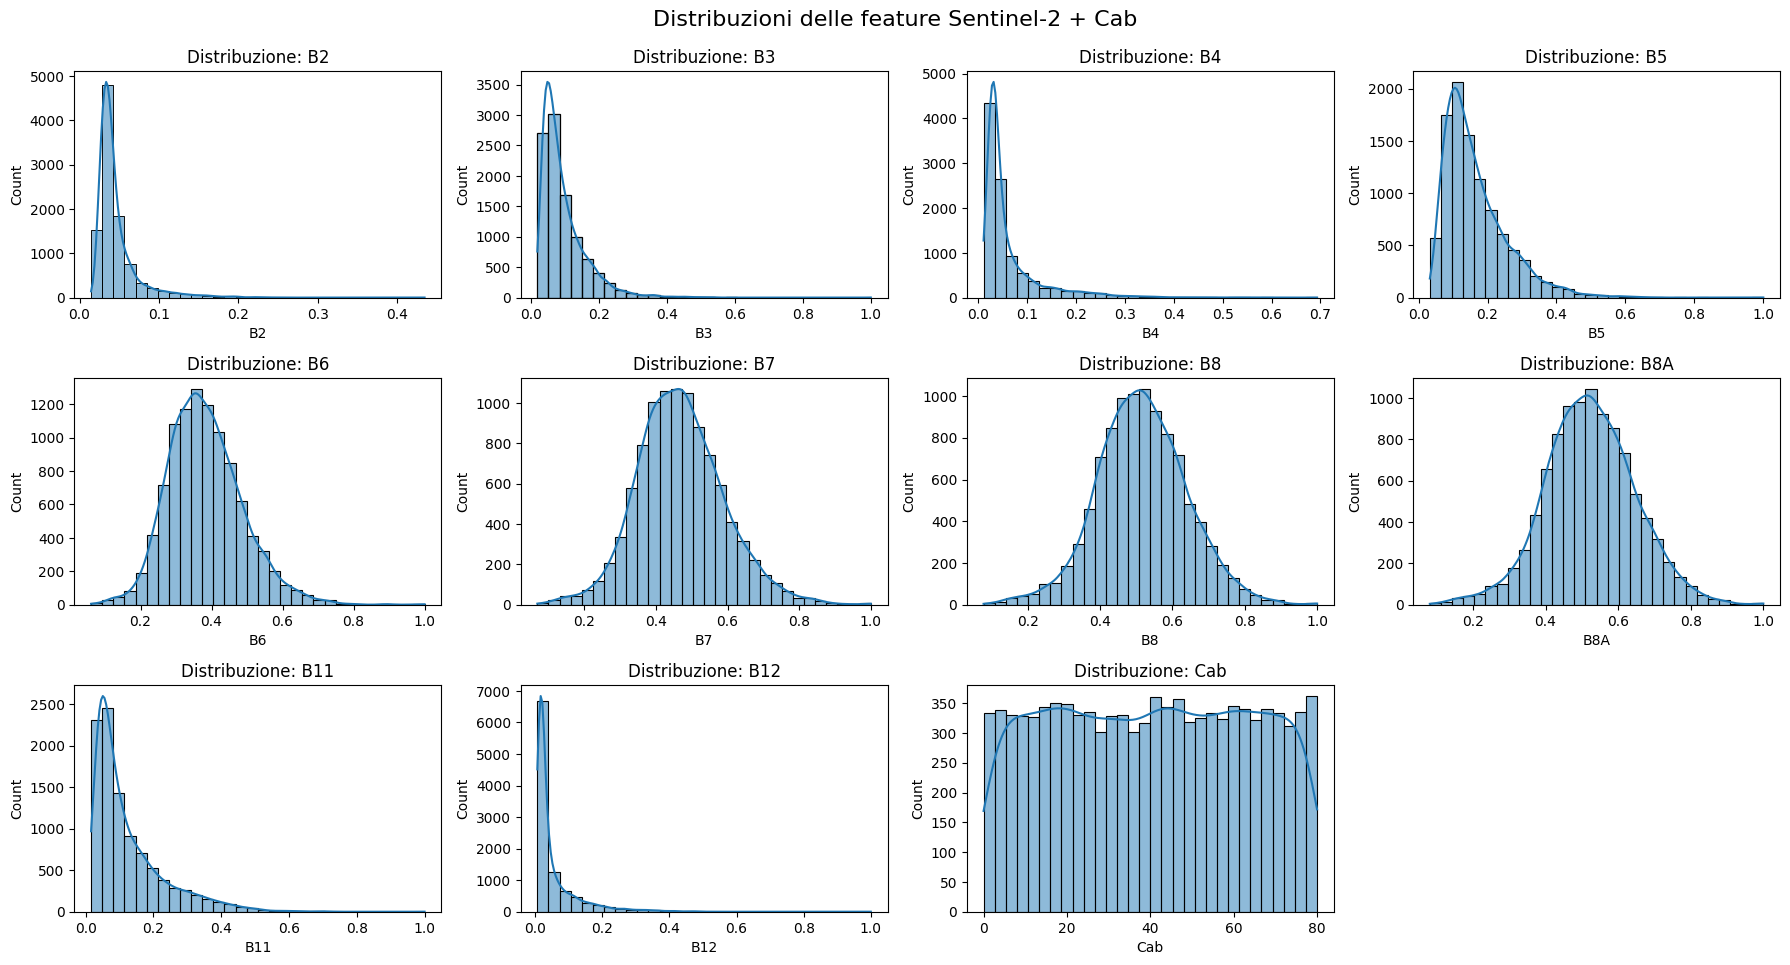

In [ ]:
plt.figure(figsize=(18, 12))
for i, column in enumerate(data.columns):
    plt.subplot(4, 4, i + 1)  # crea griglia 4x4 per massimo 16 colonne
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'Distribuzione: {column}')
    plt.tight_layout()

plt.suptitle('Distribuzioni delle feature Sentinel-2 + Cab', y=1.02, fontsize=16)
plt.show()

## Search of parameters

I train a regression model, A random forest in order to create a model which is able to predict the Cab value given the discete signature.
I use the synthetic dataset that I have created in the previous step.

### Random Forest

I split the data into train and test:
- **80% training data**
- **20% test data**

In [ ]:
X=data.drop('Cab',axis=1)
y=data['Cab']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

To evaluate the regression performance, I use:  

- **Root Mean Squared Error (RMSE)** to measure the average prediction error:  

  $$
  \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
  $$  

- **Coefficient of Determination ($R^2$)** to assess how well the model explains the variance of the target variable:  

  $$
  R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
  $$

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", math.sqrt(mse))
print("R²:", r2_score(y_test, y_pred))


RMSE: 8.005400931783546
R²: 0.8784944514407635


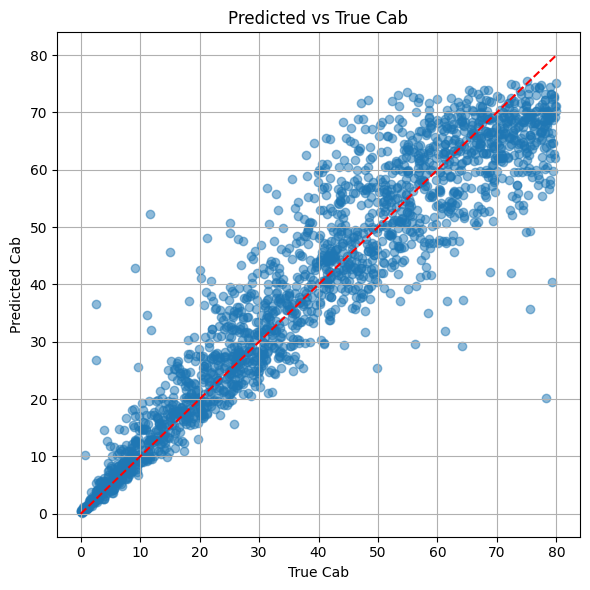

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Cab')
plt.ylabel('Predicted Cab')
plt.title('Predicted vs True Cab')
plt.grid(True)
plt.tight_layout()
plt.show()

A I expected the most importabt bands are:
- **B5**
- **B7**

Both of them are used to classify vegetation

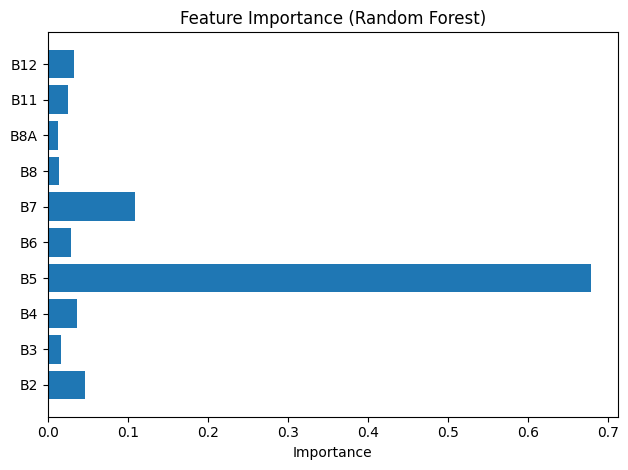

In [ ]:
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Test on sentinel-2 images

Now I want to test the model on real sentinel2 images

I select the area of interest

In [ ]:
coords = geoJSON['features'][0]['geometry']['coordinates']
roi = ee.Geometry.Polygon(coords)

Since I want to understand how the presence of Cab is changed over time I select for each moth and for each year from 2019 to 204 the first image with less cloudy percentage.

In [ ]:
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
                .filterBounds(roi) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
                .sort("CLOUDY_PIXEL_PERCENTAGE")

# Define the start and end years
start_year = 2019
end_year = 2024
# Create a list to store all monthly images for each year
all_monthly_images = []

# Iterate over each year and create monthly images
for year in range(start_year, end_year +1):
    yearly_images = create_monthly_images_for_year(year,collection)
    all_monthly_images.extend(yearly_images)

# Create an ImageCollection from the list of all monthly images
monthly_collection = ee.ImageCollection(all_monthly_images)

In [ ]:
print(monthly_collection.size().getInfo())

70


In this step, for each image I do:

1. Clipping
   - The image is cropped to the Region of Interest (ROI),  
     so we keep only the pixels that fall inside the study area.  

2. Resampling
   - Sentinel-2 bands come at different native resolutions (10 m, 20 m, 60 m).  
   - To make them comparable, we resample them using bilinear interpolation**,  
     which smooths values by considering neighboring pixels.  

3. Reprojection
   - The image is reprojected to UTM Zone 32N (EPSG:32632).  
   - The output spatial resolution is set to 20 meters per pixel.  

This ensures that all images in the collection are aligned, cropped to the ROI, and harmonized to the same resolution before further analysis.  

In [ ]:
# Apply the clip function to each image in the collection
monthly_collection = monthly_collection.map(clip_and_resample)

In [ ]:
monthly_collection

In [ ]:
# Convert the filtered collection to a list
monthly_collection_list = monthly_collection.toList(monthly_collection.size())

# Iterate over the list of filtered images
for i in range(monthly_collection.size().getInfo()):
    img = ee.Image(monthly_collection_list.get(i))
    date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    print(f"Image {i + 1}: Date = {date}")

Image 1: Date = 2019-01-15
Image 2: Date = 2019-02-19
Image 3: Date = 2019-03-01
Image 4: Date = 2019-04-18
Image 5: Date = 2019-06-14
Image 6: Date = 2019-07-24
Image 7: Date = 2019-08-26
Image 8: Date = 2019-09-05
Image 9: Date = 2019-10-10
Image 10: Date = 2019-11-04
Image 11: Date = 2019-12-31
Image 12: Date = 2020-01-25
Image 13: Date = 2020-02-17
Image 14: Date = 2020-03-20
Image 15: Date = 2020-04-07
Image 16: Date = 2020-05-22
Image 17: Date = 2020-06-28
Image 18: Date = 2020-07-21
Image 19: Date = 2020-08-02


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3185708098.py", line 7, in <cell line: 0>
    date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ee/computedobject.py", line 107, in getInfo
    return data.computeValue(self)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ee/data.py", line 1128, in computeValue
    return _execute_cloud_call(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ee/data.py", line 408, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/googleapiclient/_helpe

TypeError: object of type 'NoneType' has no len()

Now I normalize each band of each image pixel by pixel, by using minmax normalization.

In [ ]:
normalized_collection = minmax_normalize_collection(monthly_collection, BANDS)
print("Immagini normalizzate:", normalized_collection.size().getInfo())

Immagini normalizzate: 70


In [ ]:
normalized_collection

I save and export the normalized sentinel-2 images as tif file.

In [ ]:
folder=os.path.join(DATA_PATH,'GEE_Export')

In [ ]:
export_collection_to_drive(normalized_collection, folder=folder, scale=20)

In [ ]:
len(os.listdir(folder))

70

In [ ]:
FOLDER = folder
PATTERN = "*.tif"

ts, dates, profile = build_timeseries(FOLDER, PATTERN, model)

In [ ]:
show_plotly_timeseries(ts, dates, title="Cab map Predicted")


Bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
Image shape: (31, 36, 10)


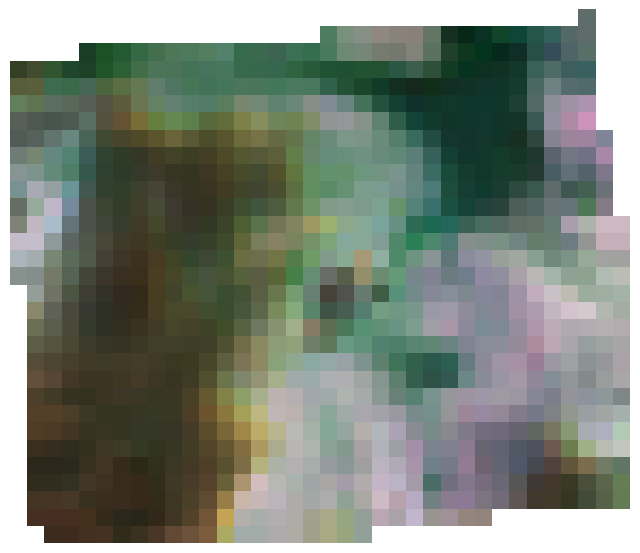

In [ ]:
files = glob.glob(os.path.join(folder, '*.tif'))
len(files)
with rasterio.open(files[3]) as src:
    stack = src.read()  # shape (bands, H, W)
    band_names = list(src.descriptions)
    print("Bands:", band_names)

    # Trasformo in (H, W, C)
    img = np.transpose(stack, (1, 2, 0))
    print("Image shape:", img.shape)

rgb_indices = [band_names.index(b) for b in ['B4','B3','B2']]
rgb = img[:, :, rgb_indices]

plt.figure(figsize=(8,8))
plt.imshow(rgb)
plt.axis('off')
plt.show()

In [ ]:
mean = monthly_collection.mean()
first = monthly_collection.first()

In [ ]:
Map = geemap.Map()
vis_param = {'min': 0,
             'max': 3000,
             'bands': ['B2','B3','B4'],
             'gamma': 1.5}

Map.addLayer(first, vis_param, 'first image')
Map.centerObject(roi, 13)
Map.addLayer(roi, {'color': 'red'}, 'ROI')

display(Map)

Map(center=[40.80178410627411, 16.72453003389994], controls=(WidgetControl(options=['position', 'transparent_b…